**This notebook presents the air temperature distribution across material quartiles. Specifically, the materials were identified through spectral unmixing of [DESIS](https://www.dlr.de/en/research-and-transfer/projects-and-missions/horizons/desis) hyperspectral imagery. The material classes include both artificial (single, metal, asphalt) and natural (bare soil, low vegetation, tall vegetation, water). The water material class was excluded from the comparative study.**

**DESIS image acquisition date is June 6 2022; therefore, material abundances are compared with the corresponding air temperature predictions in June.**

In [1]:
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.windows import from_bounds
from rasterio.coords import BoundingBox
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
desis_path = './Data/DESIS/DESIS_unmixing.tif'
air_temp_files = {
    "CP1": "./Figures_Exports/AT_outputs/pred_rf_June_CP1.tif",
    "CP2": "./Figures_Exports/AT_outputs/pred_rf_June_CP2.tif",
    "MUHI": "./Figures_Exports/AT_outputs/pred_rf_June_MUHI.tif"
}

material_mapping = {
    'Material_1': 'Shingle',
    'Material_2': 'Metal',
    'Material_3': 'Asphalt', 
    'Material_4': 'Bare soil',
    'Material_5': 'Low vegetation',
    'Material_6': 'Tall vegetation'
}
material_indices = list(material_mapping.keys())

# Load DESIS
with rasterio.open(desis_path) as desis_src:
    desis_data = desis_src.read()[:6, :, :]  # Drop water (Material_7)
    desis_transform = desis_src.transform
    desis_crs = desis_src.crs
    desis_bounds = desis_src.bounds
    desis_shape = (desis_src.height, desis_src.width)

# Flatten DESIS
desis_flat = desis_data.transpose(1, 2, 0).reshape(-1, 6)

# Quartile bin edges
bin_edges = [0.0, 0.25, 0.5, 0.75, 1.0]
labels = ['Q1', 'Q2', 'Q3', 'Q4']

df_list = []

# Load DESIS metadata
with rasterio.open(desis_path) as desis_src:
    desis_crs = desis_src.crs
    desis_bounds = desis_src.bounds
    desis_transform = desis_src.transform
    desis_count = desis_src.count

for label, path in air_temp_files.items():
    with rasterio.open(path) as temp_src:
        temp_crs = temp_src.crs
        temp_bounds = temp_src.bounds
        temp_transform = temp_src.transform
        temp_shape = (temp_src.height, temp_src.width)

        # Reproject DESIS boundaries to find the overlap with AT prediction rasters
        desis_bounds_in_temp = rasterio.warp.transform_bounds(desis_crs, temp_crs, *desis_bounds)

        # Compute intersection between DESIS and AT
        intersection = BoundingBox(
            left=max(temp_bounds.left, desis_bounds_in_temp[0]),
            bottom=max(temp_bounds.bottom, desis_bounds_in_temp[1]),
            right=min(temp_bounds.right, desis_bounds_in_temp[2]),
            top=min(temp_bounds.top, desis_bounds_in_temp[3])
        )

        if intersection.left >= intersection.right or intersection.bottom >= intersection.top:
            continue

        # Read temp data from intersection
        temp_window = from_bounds(*intersection, transform=temp_transform)
        temp_data = temp_src.read(1, window=temp_window)
        temp_window_transform = temp_src.window_transform(temp_window)
        temp_height, temp_width = temp_data.shape

    # Re-open DESIS and read intersection
    with rasterio.open(desis_path) as desis_src:
        intersection_in_desis = rasterio.warp.transform_bounds(temp_crs, desis_crs, *intersection)

        desis_window = from_bounds(*intersection_in_desis, transform=desis_transform)
        desis_data = desis_src.read(indexes=range(1, 7), window=desis_window)  # 6 materials only
        desis_window_transform = desis_src.window_transform(desis_window)

        # Resample DESIS to match AT shape/grid
        desis_resampled = np.empty((6, temp_height, temp_width), dtype=np.float32)
        for i in range(6):
            reproject(
                source=desis_data[i],
                destination=desis_resampled[i],
                src_transform=desis_window_transform,
                src_crs=desis_crs,
                dst_transform=temp_window_transform,
                dst_crs=temp_crs,
                dst_width=temp_width,
                dst_height=temp_height,
                resampling=Resampling.bilinear
            )

    # Flatten
    desis_flat = desis_resampled.transpose(1, 2, 0).reshape(-1, 6)
    temp_flat = temp_data.flatten()

    # Mask invalid pixels
    valid_mask = (~np.isnan(temp_flat)) & (~np.isnan(desis_flat).any(axis=1))
    temp_valid = temp_flat[valid_mask]
    desis_valid = desis_flat[valid_mask]

    # Build df
    for i, mat_key in enumerate(material_indices):
        mat_values = np.clip(desis_valid[:, i], 0, 1)
        quartiles = pd.cut(mat_values, bins=bin_edges, labels=labels, include_lowest=True, right=False)

        df = pd.DataFrame({
            'AirTemp': temp_valid,
            'Material': material_mapping[mat_key],
            'Material_Quartile': quartiles,
            'Source': label
        })

        df_list.append(df.dropna(subset=['Material_Quartile']))

# Final df
plot_df = pd.concat(df_list, ignore_index=True)

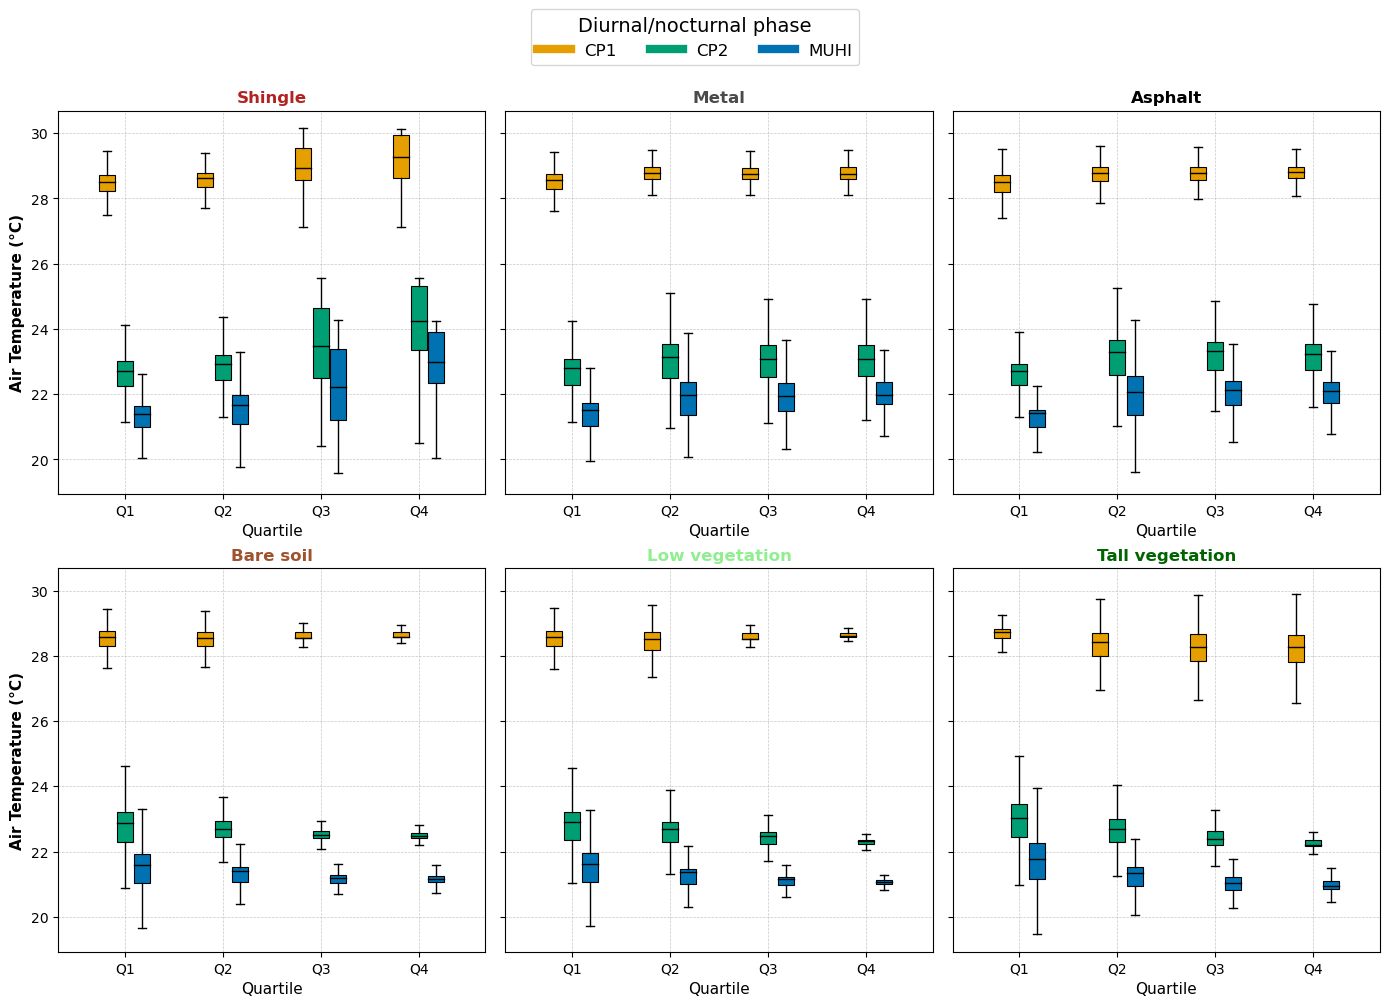

In [4]:
materials_to_plot = list(material_mapping.values())
quartiles = ['Q1', 'Q2', 'Q3', 'Q4']
sources = list(air_temp_files.keys())

source_colors = {
    'CP1': '#E69F00',   
    'CP2': '#009E73',   
    'MUHI': '#0072B2'   
}

# Color mapping for material frame and title
material_colors = {
    'Shingle': '#B22222',     
    'Metal': '#4B4B4B',
    'Asphalt': '#000000',         
    'Bare soil': '#A0522D',      
    'Low vegetation': '#90EE90',
    'Tall vegetation': '#006400'
}

# Setup 3x2 layout
fig, axes = plt.subplots(2, 3, figsize=(14, 10), sharey=True)
axes = axes.flatten()

for ax, material in zip(axes, materials_to_plot):
    data = plot_df[plot_df['Material'] == material]

    positions = np.arange(len(quartiles))
    width = 0.18
    offset = -width * (len(sources) - 1) / 2

    for i, source in enumerate(sources):
        values_per_quartile = []
        for q in quartiles:
            vals = data[(data['Material_Quartile'] == q) & (data['Source'] == source)]['AirTemp'].values
            values_per_quartile.append(vals)
            
        bp = ax.boxplot(
            values_per_quartile,
            positions=positions + offset + i * width,
            widths=width * 0.9,
            patch_artist=True,
            showfliers=False,
            showmeans=True,
            meanline=True,   # show mean as a line, not a point
            medianprops=dict(linewidth=0),  # completely hide the median
            meanprops=dict(color='black', linewidth=1.5, linestyle='-')  # solid mean line
        )

        for patch in bp['boxes']:
            patch.set_facecolor(source_colors[source])
            patch.set_edgecolor('black')
            patch.set_linewidth(0.8)
        for line in bp['means']:
            line.set_color('black')
            line.set_linewidth(1)

    ax.set_xticks(positions)
    ax.set_xticklabels(quartiles, fontsize=10)
    ax.set_xlabel("Quartile", fontsize=11)

    if ax in [axes[0], axes[3]]:  # left column
        ax.set_ylabel("Air Temperature (°C)", fontsize=11, weight='bold')
    else:
        ax.set_ylabel("")

    ax.set_title(material, fontsize=12, weight='bold', color=material_colors.get(material, 'black'))
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Remove any unused subplots
# for ax in axes[len(materials_to_plot):]:
#     ax.set_visible(False)

# Shared legend
handles = [plt.Line2D([0], [0], color=source_colors[src], lw=6) for src in sources]
fig.legend(
    handles,
    sources,
    title="Diurnal/nocturnal phase",
    loc='upper center',
    bbox_to_anchor=(0.5, 1.01),
    ncol=len(sources),
    frameon=True,
    fontsize=12,
    title_fontsize=14
)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig("./Figures_Exports/AT_per_material_boxplots.png", dpi=600, bbox_inches='tight')
plt.show()